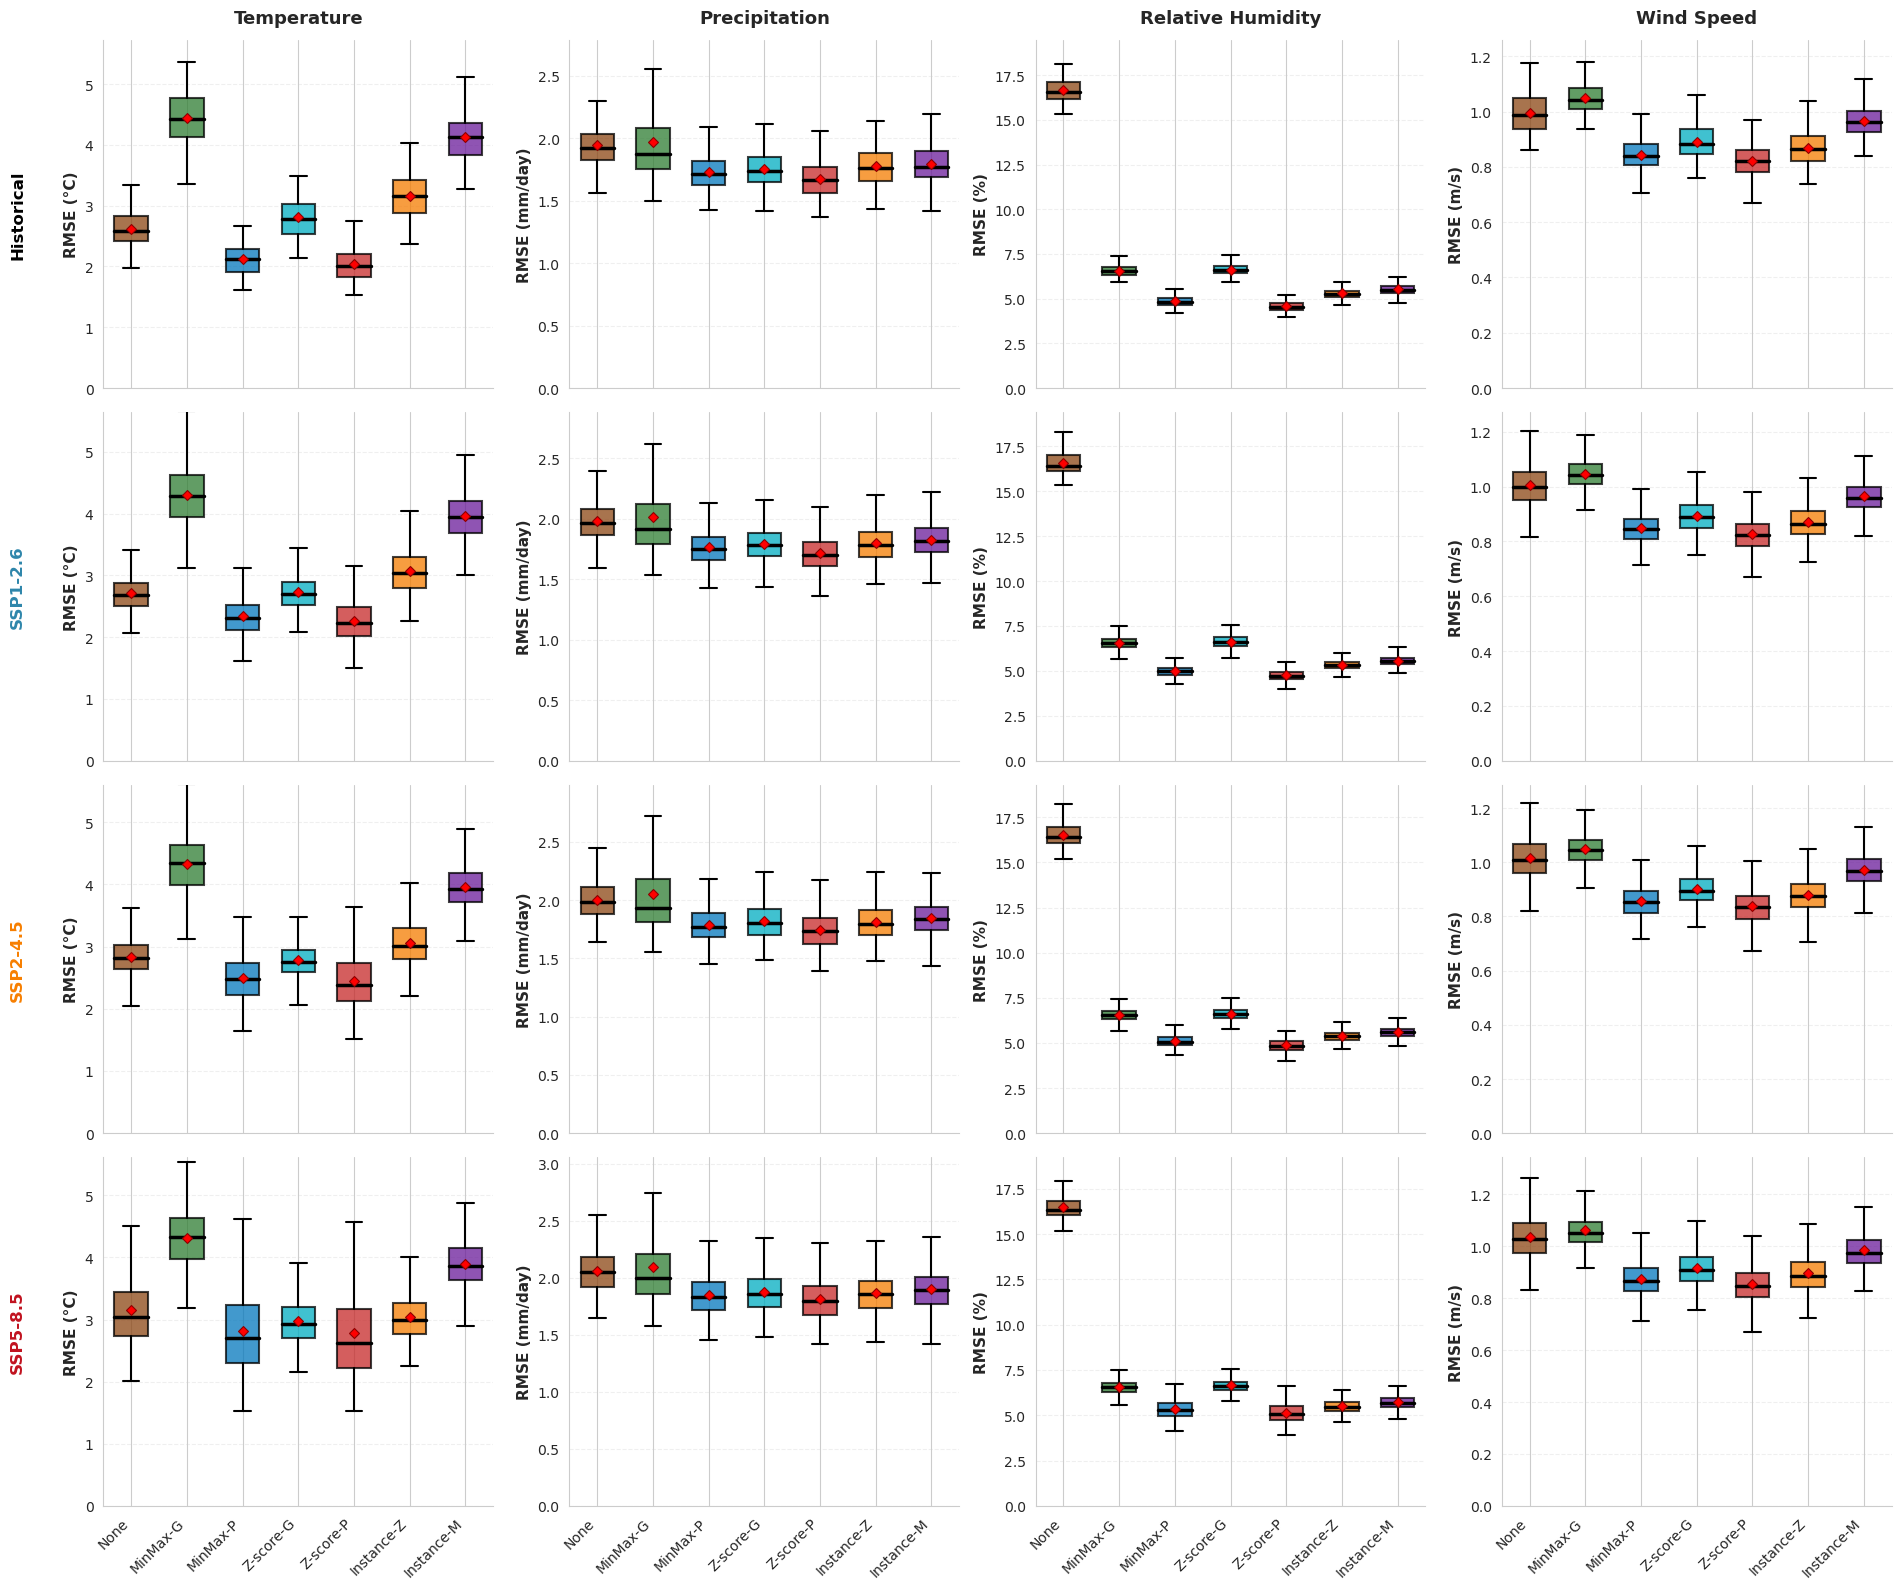

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Load evaluation results
eval_dir = Path("evaluation_results")
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']

# Variables configuration
variables = [
    {'name': 'tas', 'label': 'Temperature', 'unit': '°C'},
    {'name': 'pr', 'label': 'Precipitation', 'unit': 'mm/day'},
    {'name': 'hurs', 'label': 'Relative Humidity', 'unit': '%'},
    {'name': 'sfcWind', 'label': 'Wind Speed', 'unit': 'm/s'}
]

# Load all data
all_data = {}
for var in variables:
    all_data[var['name']] = {}
    for scenario in scenarios:
        ds = xr.open_dataset(eval_dir / f"{var['name']}_evaluation_{scenario}.nc")
        all_data[var['name']][scenario] = ds

def collect_spatial_metrics_timeseries(predictions, groundtruth):
    """
    Calculate spatial metrics for each time point.
    Returns arrays of metrics for each time step.
    """
    n_time = predictions.shape[0]
    rmse_values = []
    
    for t in range(n_time):
        pred_2d = predictions[t].flatten()
        gt_2d = groundtruth[t].flatten()
        
        # RMSE
        rmse = np.sqrt(np.mean((pred_2d - gt_2d)**2))
        rmse_values.append(rmse)
    
    return np.array(rmse_values)

# Normalization methods - INCLUDING 'none'
norm_methods = ['none', 'minmax_global', 'minmax_pixel', 'zscore_global', 
                'zscore_pixel', 'instance_zscore', 'instance_minmax']

# Model labels for display
model_labels = {
    'none': 'None',
    'minmax_global': 'MinMax-G',
    'minmax_pixel': 'MinMax-P',
    'zscore_global': 'Z-score-G',
    'zscore_pixel': 'Z-score-P',
    'instance_zscore': 'Instance-Z',
    'instance_minmax': 'Instance-M'
}

# Colors for each model
model_colors = {
    'none': '#8B4513',        # Saddle Brown
    'minmax_global': '#2E7D32',  # Dark Green
    'minmax_pixel': '#0277BD',   # Dark Blue
    'zscore_global': '#00ACC1',  # CYAN
    'zscore_pixel': '#C62828',   # Dark Red
    'instance_zscore': '#F57C00', # Dark Orange
    'instance_minmax': '#6A1B9A'  # Dark Purple
}

# Scenario colors
scenario_colors = {
    'historical': '#000000',
    'ssp126': '#2E86AB',
    'ssp245': '#F77F00',
    'ssp585': '#C1121F'
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Collect all metrics
metrics_data = {}

for var in variables:
    var_name = var['name']
    metrics_data[var_name] = {}
    
    for scenario in scenarios:
        ds = all_data[var_name][scenario]
        metrics_data[var_name][scenario] = {}
        
        # Get ground truth
        gt_data = ds['groundtruth'].values  # Shape: (time, lat, lon)
        
        for norm_method in norm_methods:
            pred_key = f'pred_{norm_method}'
            if pred_key in ds:
                pred_data = ds[pred_key].values  # Shape: (time, lat, lon)
                
                # Calculate RMSE for each time step
                rmse_ts = collect_spatial_metrics_timeseries(pred_data, gt_data)
                
                metrics_data[var_name][scenario][norm_method] = {
                    'rmse': rmse_ts
                }

# Create 4x4 box plot figure (4 scenarios × 4 variables)
fig, axes = plt.subplots(4, 4, figsize=(20, 16))

# Create box plots
for row, scenario in enumerate(scenarios):
    for col, var in enumerate(variables):
        var_name = var['name']
        var_label = var['label']
        var_unit = var['unit']
        
        ax = axes[row, col]
        
        # Prepare data for box plot
        box_data = []
        positions = []
        colors = []
        
        for i, norm in enumerate(norm_methods):
            if norm in metrics_data[var_name][scenario]:
                data = metrics_data[var_name][scenario][norm]['rmse']
                box_data.append(data)
                positions.append(i + 1)
                colors.append(model_colors[norm])
        
        # Create box plot
        bp = ax.boxplot(box_data, positions=positions, widths=0.6,
                        patch_artist=True, showfliers=False,
                        medianprops=dict(color='black', linewidth=2.5),
                        boxprops=dict(linewidth=1.5),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.75)
        
        # Formatting
        ax.set_xticks(positions)
        
        # Only show x-axis labels on bottom row
        if row == 3:
            ax.set_xticklabels([model_labels[norm] for norm in norm_methods], 
                              rotation=45, ha='right', fontsize=10)
        else:
            ax.set_xticklabels([])
        
        # Auto-scale for RMSE
        if len(box_data) > 0:
            all_rmse = np.concatenate(box_data)
            ax.set_ylim(0, np.percentile(all_rmse, 99) * 1.1)
        
        # Y-axis labels - NOW ALL COLUMNS GET LABELS
        ax.set_ylabel(f'RMSE ({var_unit})', fontsize=11, fontweight='bold')
        
        # Column titles on top row - Variable names
        if row == 0:
            ax.set_title(var_label, fontsize=13, fontweight='bold', pad=12)
        
        # Add scenario label on leftmost column
        if col == 0:
            ax.text(-0.22, 0.5, scenario_labels[scenario], 
                   transform=ax.transAxes,
                   fontsize=12, fontweight='bold',
                   rotation=90, va='center', ha='center',
                   color=scenario_colors[scenario])
        
        # Grid
        ax.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=0.8)
        ax.set_axisbelow(True)
        
        # Add mean marker (red diamond)
        for i, data_values in enumerate(box_data):
            mean_val = np.mean(data_values)
            ax.plot(positions[i], mean_val, 'D', color='red', 
                   markersize=5, zorder=10, markeredgecolor='darkred', markeredgewidth=0.8)
        
        ax.tick_params(labelsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Adjust layout - REMOVED big title
plt.tight_layout(rect=[0.05, 0, 1, 1.0])

# Save
plt.savefig('spatial_rmse_boxplot_all_variables.png', dpi=600, bbox_inches='tight')
plt.savefig('spatial_rmse_boxplot_all_variables.pdf', bbox_inches='tight')

plt.show()

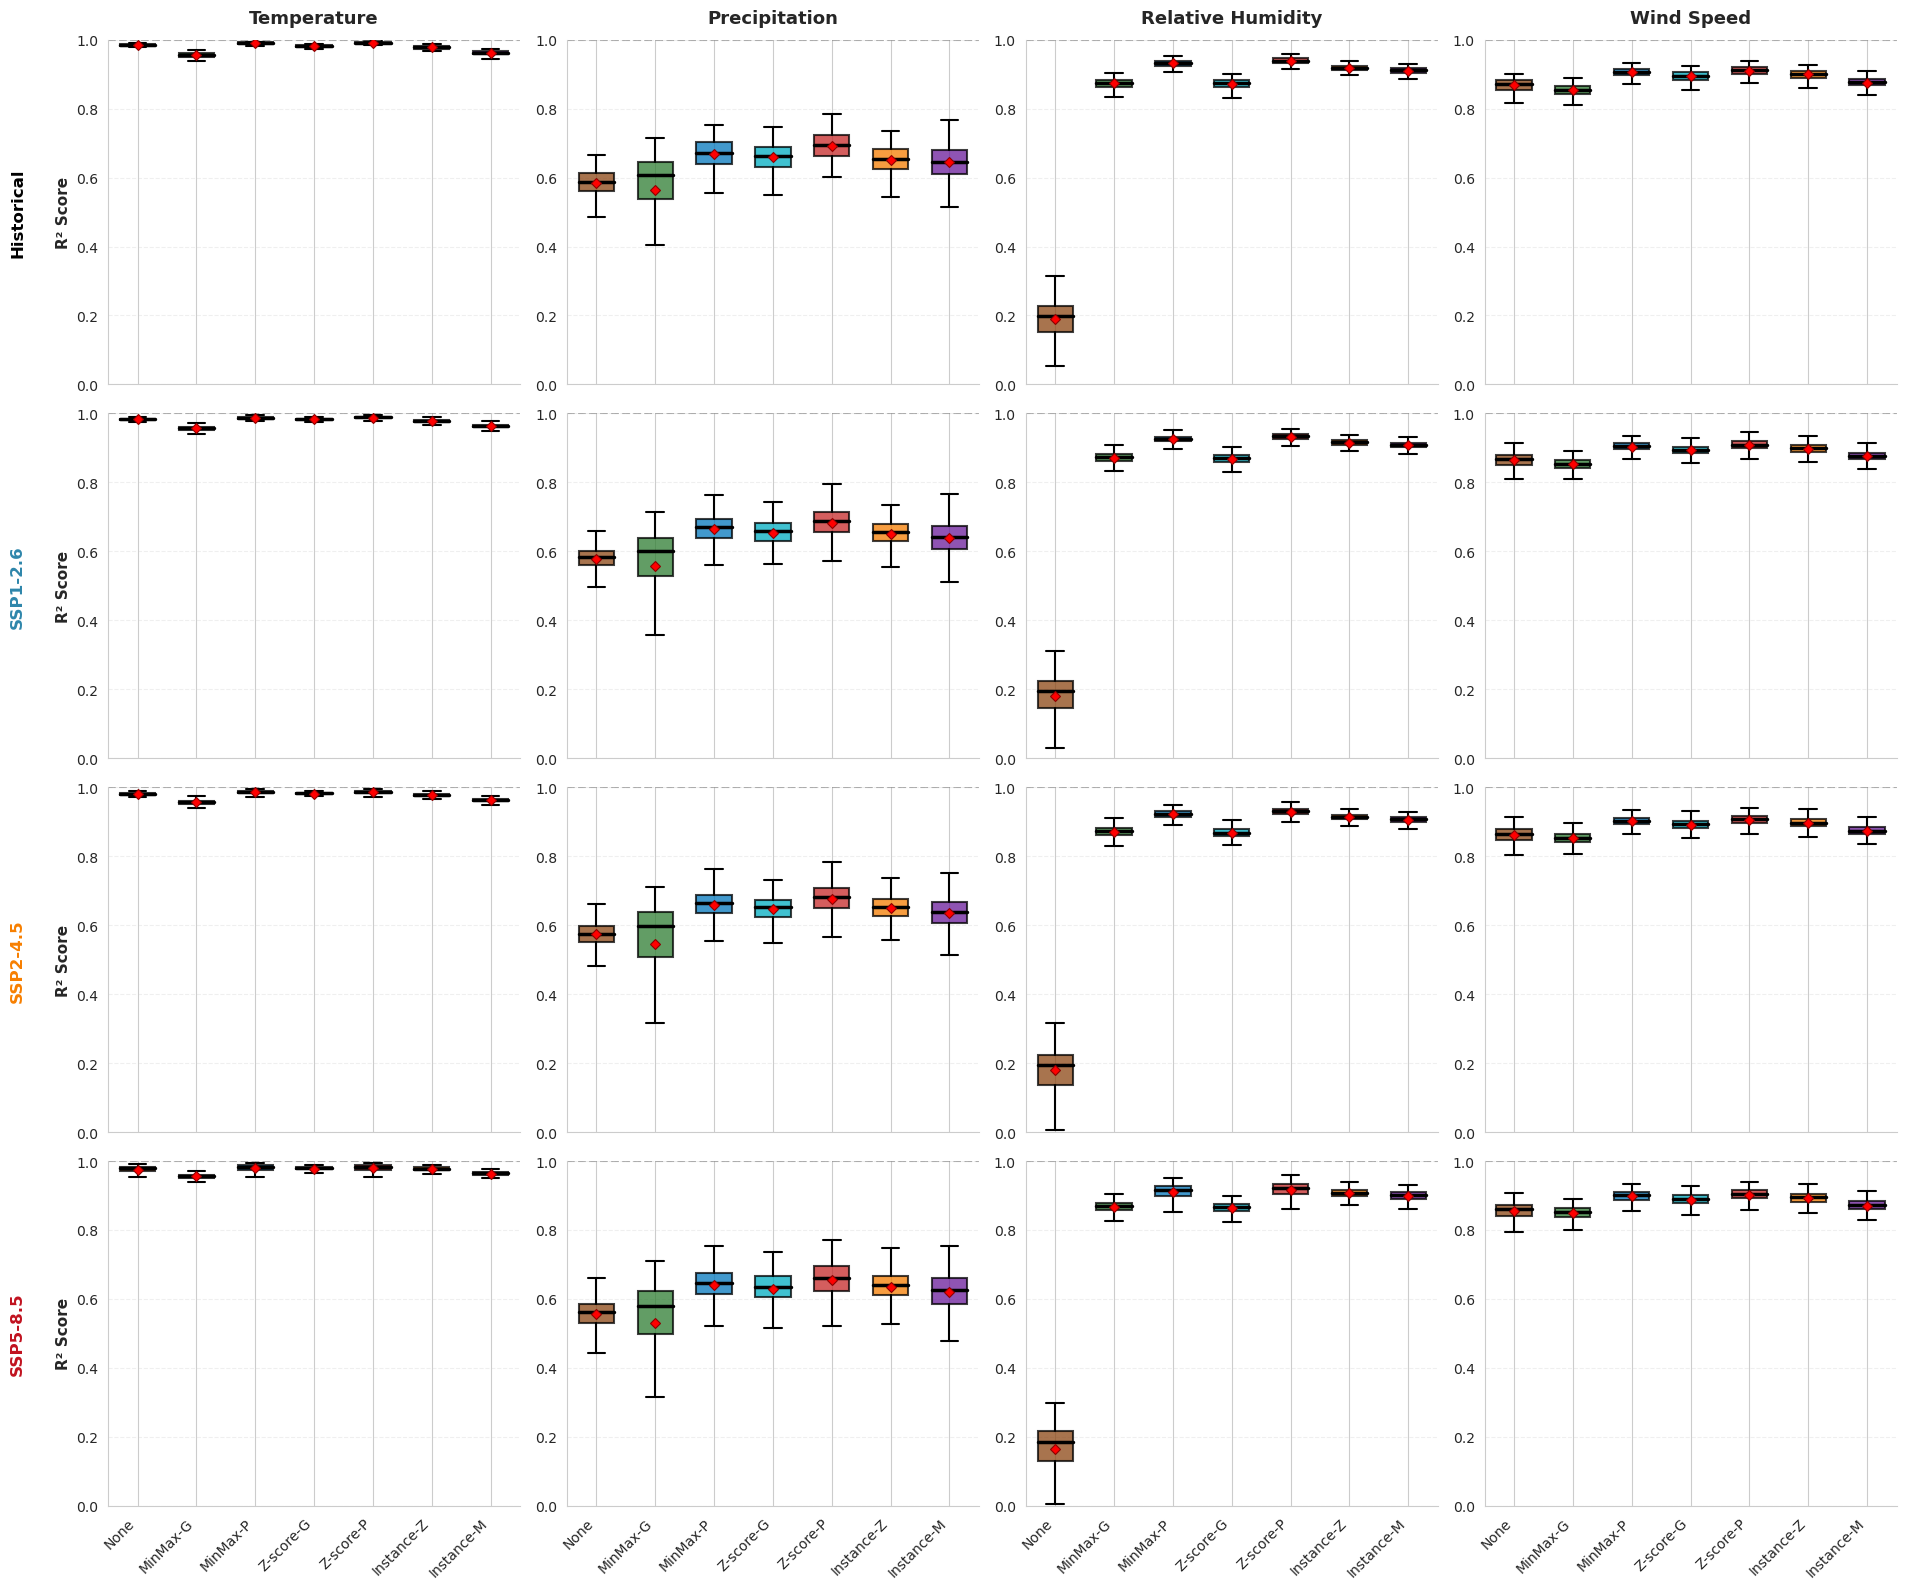

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Load evaluation results
eval_dir = Path("evaluation_results")
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']

# Variables configuration
variables = [
    {'name': 'tas', 'label': 'Temperature', 'unit': '°C'},
    {'name': 'pr', 'label': 'Precipitation', 'unit': 'mm/day'},
    {'name': 'hurs', 'label': 'Relative Humidity', 'unit': '%'},
    {'name': 'sfcWind', 'label': 'Wind Speed', 'unit': 'm/s'}
]

# Load all data
all_data = {}
for var in variables:
    all_data[var['name']] = {}
    for scenario in scenarios:
        ds = xr.open_dataset(eval_dir / f"{var['name']}_evaluation_{scenario}.nc")
        all_data[var['name']][scenario] = ds

def collect_spatial_metrics_timeseries(predictions, groundtruth):
    """
    Calculate spatial metrics for each time point.
    Returns arrays of metrics for each time step.
    """
    n_time = predictions.shape[0]
    r2_values = []
    
    for t in range(n_time):
        pred_2d = predictions[t].flatten()
        gt_2d = groundtruth[t].flatten()
        
        # R²
        if np.std(gt_2d) > 0:
            r2 = 1 - (np.sum((pred_2d - gt_2d)**2) / np.sum((gt_2d - np.mean(gt_2d))**2))
        else:
            r2 = np.nan
        r2_values.append(r2)
    
    return np.array(r2_values)

# Normalization methods - INCLUDING 'none'
norm_methods = ['none', 'minmax_global', 'minmax_pixel', 'zscore_global', 
                'zscore_pixel', 'instance_zscore', 'instance_minmax']

# Model labels for display
model_labels = {
    'none': 'None',
    'minmax_global': 'MinMax-G',
    'minmax_pixel': 'MinMax-P',
    'zscore_global': 'Z-score-G',
    'zscore_pixel': 'Z-score-P',
    'instance_zscore': 'Instance-Z',
    'instance_minmax': 'Instance-M'
}

# Colors for each model
model_colors = {
    'none': '#8B4513',        # Saddle Brown
    'minmax_global': '#2E7D32',  # Dark Green
    'minmax_pixel': '#0277BD',   # Dark Blue
    'zscore_global': '#00ACC1',  # CYAN
    'zscore_pixel': '#C62828',   # Dark Red
    'instance_zscore': '#F57C00', # Dark Orange
    'instance_minmax': '#6A1B9A'  # Dark Purple
}

# Scenario colors
scenario_colors = {
    'historical': '#000000',
    'ssp126': '#2E86AB',
    'ssp245': '#F77F00',
    'ssp585': '#C1121F'
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Collect all metrics
metrics_data = {}

for var in variables:
    var_name = var['name']
    metrics_data[var_name] = {}
    
    for scenario in scenarios:
        ds = all_data[var_name][scenario]
        metrics_data[var_name][scenario] = {}
        
        # Get ground truth
        gt_data = ds['groundtruth'].values  # Shape: (time, lat, lon)
        
        for norm_method in norm_methods:
            pred_key = f'pred_{norm_method}'
            if pred_key in ds:
                pred_data = ds[pred_key].values  # Shape: (time, lat, lon)
                
                # Calculate R² for each time step
                r2_ts = collect_spatial_metrics_timeseries(pred_data, gt_data)
                
                metrics_data[var_name][scenario][norm_method] = {
                    'r2': r2_ts
                }

# Create 4x4 box plot figure (4 scenarios × 4 variables)
fig, axes = plt.subplots(4, 4, figsize=(20, 16))

# Create box plots
for row, scenario in enumerate(scenarios):
    for col, var in enumerate(variables):
        var_name = var['name']
        var_label = var['label']
        
        ax = axes[row, col]
        
        # Prepare data for box plot
        box_data = []
        positions = []
        colors = []
        
        for i, norm in enumerate(norm_methods):
            if norm in metrics_data[var_name][scenario]:
                data = metrics_data[var_name][scenario][norm]['r2']
                # Remove NaN values for R²
                data = data[~np.isnan(data)]
                box_data.append(data)
                positions.append(i + 1)
                colors.append(model_colors[norm])
        
        # Create box plot
        bp = ax.boxplot(box_data, positions=positions, widths=0.6,
                        patch_artist=True, showfliers=False,
                        medianprops=dict(color='black', linewidth=2.5),
                        boxprops=dict(linewidth=1.5),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.75)
        
        # Formatting
        ax.set_xticks(positions)
        
        # Only show x-axis labels on bottom row
        if row == 3:
            ax.set_xticklabels([model_labels[norm] for norm in norm_methods], 
                              rotation=45, ha='right', fontsize=10)
        else:
            ax.set_xticklabels([])
        
        # Set y-axis limits for R² (0 to 1)
        ax.set_ylim(0, 1.0)
        
        # Y-axis labels only on leftmost column (R² has no unit)
        if col == 0:
            ax.set_ylabel('R² Score', fontsize=11, fontweight='bold')
        else:
            ax.set_ylabel('')
        
        # Column titles on top row - Variable names
        if row == 0:
            ax.set_title(var_label, fontsize=13, fontweight='bold', pad=12)
        
        # Add scenario label on leftmost column
        if col == 0:
            ax.text(-0.22, 0.5, scenario_labels[scenario], 
                   transform=ax.transAxes,
                   fontsize=12, fontweight='bold',
                   rotation=90, va='center', ha='center',
                   color=scenario_colors[scenario])
        
        # Grid
        ax.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=0.8)
        ax.set_axisbelow(True)
        
        # Add mean marker (red diamond)
        for i, data_values in enumerate(box_data):
            mean_val = np.mean(data_values)
            ax.plot(positions[i], mean_val, 'D', color='red', 
                   markersize=5, zorder=10, markeredgecolor='darkred', markeredgewidth=0.8)
        
        # Add reference line at R² = 1
        ax.axhline(y=1.0, color='gray', linestyle='--', 
                  linewidth=1.5, alpha=0.6)
        
        ax.tick_params(labelsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout(rect=[0.05, 0, 1, 1.0])

# Save
plt.savefig('spatial_r2_boxplot_all_variables.png', dpi=600, bbox_inches='tight')
plt.savefig('spatial_r2_boxplot_all_variables.pdf', bbox_inches='tight')

plt.show()